# Predicting Lego Set Prices
As new lego sets approach release, there are rumors and leaks, sometimes containing all of the details of the set.
The objective of this model is to be able to predict as accurately as possible, from the available information what hte price of these sets is going to be.

In [4]:
#Imports
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import category_encoders as ce
from category_encoders import BinaryEncoder
print('imported')

imported


Here we import the data generated from the LegoEDA project.

In [5]:
#read in clean data
lego_mod_df = pd.read_csv('legoData_mod.csv')
lego_mod_df.head


<bound method NDFrame.head of       Unnamed: 0 Set_number                       Name Set_type       Theme  \
0            212      702-2            Small Basic Set   Normal   SAMSONITE   
1            217      717-1         Junior Constructor   Normal   SAMSONITE   
2            218      725-3                  Town Plan   Normal   SAMSONITE   
3            279      450-2        Deluxe Building Set   Normal   SAMSONITE   
4            281      615-1         Samsonite Gift Set   Normal   SAMSONITE   
...          ...        ...                        ...      ...         ...   
6787       19108    80043-1       Yellow Tusk Elephant   Normal  MONKIE KID   
6788       19109    80044-1  Monkie Kid's Team Hideout   Normal  MONKIE KID   
6789       19110    80045-1     Monkey King Ultra Mech   Normal  MONKIE KID   
6790       19111    80110-1     Lunar New Year Display   Normal    SEASONAL   
6791       19112    80111-1      Lunar New Year Parade   Normal    SEASONAL   

           Theme_grou

Just a reminder of what the data looks like

In [6]:
#Numerical features, without Price, which is our target variable
lego_num_cols=['Year_released', 'Pieces', 'Minifigs']
#Categorical features
lego_cat_cols=['Set_number', 'Name', 'Set_type', 'Theme', 'Theme_group', 'Subtheme', 'Age_range']
lego_num = lego_mod_df[lego_num_cols]
lego_cat = lego_mod_df[lego_cat_cols]

for i in lego_cat.columns:
    print("Unique "+ str(i)+ "s: "+ str(len(lego_cat[i].unique())))
    print("Nulls in "+ str(i)+ ": "+ str(lego_cat[i].isna().sum()))

Unique Set_numbers: 6792
Nulls in Set_number: 0
Unique Names: 6154
Nulls in Name: 0
Unique Set_types: 4
Nulls in Set_type: 0
Unique Themes: 133
Nulls in Theme: 0
Unique Theme_groups: 14
Nulls in Theme_group: 0
Unique Subthemes: 541
Nulls in Subtheme: 0
Unique Age_ranges: 48
Nulls in Age_range: 2573


## Split to features and target

In [8]:
y = lego_mod_df.Price
X = lego_mod_df.drop(['Price'], axis=1)



## Define model function
Here I define a function that reads in the preprocessor and the data itself.
It then does a cross validation to output the desired scoring parameters.
I am going to look at three parameters, the r2, mean squared error (MSE) and mean absolute error (MAE).
MSE will be the main gauge of how the model improves. 
MAE is just included as it is in the same scale as the input data and is more intuitive to look at.

In [9]:
def linear_model(preprocessor,X,y):    


    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', LinearRegression(fit_intercept=True))
                             ])
    
    scoring = ['r2','neg_mean_squared_error','neg_mean_absolute_error']
    scores = cross_validate(my_pipeline, X, y,
                              cv=5,
                              scoring=scoring,
                              return_train_score=True)

    print("mean r2: train = "+str(scores['train_r2'].mean())+", test = "+str(scores['test_r2'].mean()))
    print("mean MSE: train = "+str(-1*scores['train_neg_mean_squared_error'].mean())+", test = "+str(-1*scores['test_neg_mean_squared_error'].mean()))
    print("mean MAE: train = "+str(-1*scores['train_neg_mean_absolute_error'].mean())+", test = "+str(-1*scores['test_neg_mean_absolute_error'].mean()))
    return -1*scores['test_neg_mean_squared_error'].mean()

## Preprocessing
### Numerical Data
I want to scall all of my variables to between 0 and 1, I first do this for only pieces, as this is the most correlated feature with price, to get a baseline of measurements for my model.

In [10]:
scaler  = preprocessing.MinMaxScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, ['Pieces',]),
    ],
    remainder = 'drop'
)

linear_model(preprocessor,X,y)  


mean r2: train = 0.742636234392063, test = 0.6821672940644106
mean MSE: train = 820.1188141446519, test = 862.7264739631546
mean MAE: train = 13.164811833419785, test = 13.33891455338169


862.7264739631546

Next I add in minifigs

In [11]:
scaler  = preprocessing.MinMaxScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, ['Pieces','Minifigs']),
    ],
    remainder = 'drop'
)
linear_model(preprocessor,X,y)  

mean r2: train = 0.7543667398144124, test = 0.6979754646948189
mean MSE: train = 782.1680629351251, test = 819.9908335903867
mean MAE: train = 12.196057810704678, test = 12.389671728137037


819.9908335903867

We can see the MSE and MAE drop significantly, as well as a slight increase in r2

the next step is to add in release year.

In [12]:
scaler  = preprocessing.MinMaxScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, ['Pieces','Minifigs','Year_released']),
    ],
    remainder = 'drop'
)

linear_model(preprocessor,X,y)  

mean r2: train = 0.7549504259204467, test = 0.6980794905126244
mean MSE: train = 780.3653488051059, test = 820.8619913483968
mean MAE: train = 12.176531429334343, test = 12.591888657238945


820.8619913483968

Release_year was not very correlated with price, and we notice our indicators going slightly in the wrong direction. Maybe adding polynomials will fix this?

In [13]:
scaler  = preprocessing.MinMaxScaler()
polyn = preprocessing.PolynomialFeatures(2) 

numerical_transformer = Pipeline(steps=[
    ('scale', scaler),
    ('poly', polyn)
])



preprocessor = ColumnTransformer(
    transformers=[('num', numerical_transformer, ['Pieces','Minifigs','Year_released']),
        
    ],
    remainder = 'drop'
)

linear_model(preprocessor,X,y)  

mean r2: train = 0.7749315938821855, test = 0.7154143708289226
mean MSE: train = 714.4462269319782, test = 763.5331584973768
mean MAE: train = 11.68228134070396, test = 12.083181969048756


763.5331584973768

We can see that adding 2nd order polynomials decreases MAE and MSE on the test data, however going beyond this causes overfitting.

However the inclusion of Year_released is still detremental to the model. I am going to graph the MSE of the data vs cutout year below. (I exclude the last ten years as this would remove too much data from the pool)

1961
mean r2: train = 0.7749315938821855, test = 0.7154143708289226
mean MSE: train = 714.4462269319782, test = 763.5331584973768
mean MAE: train = 11.68228134070396, test = 12.083181969048756
1962
mean r2: train = 0.7749064884359042, test = 0.715625942819538
mean MSE: train = 714.7627409179998, test = 763.5614057041059
mean MAE: train = 11.684648141957355, test = 12.077943308648916
1963
mean r2: train = 0.7749064884359042, test = 0.715625942819538
mean MSE: train = 714.7627409179998, test = 763.5614057041059
mean MAE: train = 11.684648141957355, test = 12.077943308648916
1964
mean r2: train = 0.7751889825449305, test = 0.716842040109339
mean MSE: train = 713.9657421375427, test = 764.3544947909365
mean MAE: train = 11.639959122588019, test = 12.022769583578384
1965
mean r2: train = 0.7751110732264257, test = 0.7164668853457681
mean MSE: train = 714.606782337094, test = 765.3406422237064
mean MAE: train = 11.644640248586484, test = 12.051537675981963
1966
mean r2: train = 0.77509675689

mean r2: train = 0.7892527984103348, test = 0.7305878282526453
mean MSE: train = 796.377514761439, test = 907.2094999152889
mean MAE: train = 11.751519693165918, test = 13.137778091577587
2005
mean r2: train = 0.7945789454593661, test = 0.7453638415397434
mean MSE: train = 790.2873442214302, test = 886.1246517319669
mean MAE: train = 11.640597769523954, test = 12.9104827917764
2006
mean r2: train = 0.7957642505493018, test = 0.7536845571694548
mean MSE: train = 797.5322250237971, test = 883.4999511153883
mean MAE: train = 11.62408036092606, test = 12.97169939504074
2007
mean r2: train = 0.8004366576623312, test = 0.7679783696351493
mean MSE: train = 792.1106057201056, test = 863.1455683916778
mean MAE: train = 11.528131493513866, test = 12.70041814612867
2008
mean r2: train = 0.8010872900766284, test = 0.764920463324219
mean MSE: train = 793.9717374712515, test = 880.956857948174
mean MAE: train = 11.543372448509146, test = 12.689691606960839
2009
mean r2: train = 0.8024013843192653, t

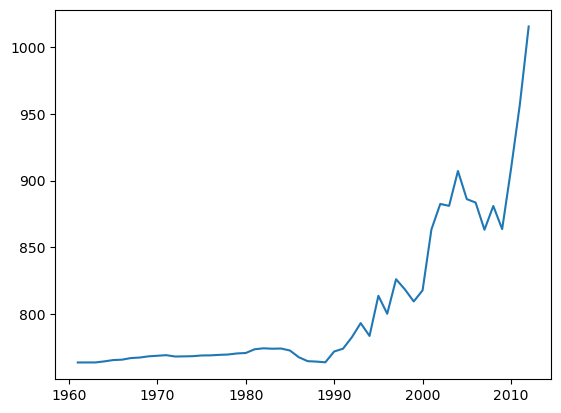

In [14]:
year_list = []
MSE_list = []
for year in range(int(lego_mod_df.Year_released.min()),int(lego_mod_df.Year_released.max())-10):
    lego_mod_postdate_df = lego_mod_df[lego_mod_df.Year_released >= year]
    y_new = lego_mod_postdate_df.Price
    X_new = lego_mod_postdate_df.drop(['Price'], axis=1)


    scaler  = preprocessing.MinMaxScaler()
    polyn = preprocessing.PolynomialFeatures(2) 

    numerical_transformer = Pipeline(steps=[
        ('scale', scaler),
        ('poly', polyn)
    ])
    print(year)
    preprocessor = ColumnTransformer(
        transformers=[('num', numerical_transformer, ['Pieces','Minifigs','Year_released']),

        ],
    remainder = 'drop'
    )

    year_list.append(year)
    MSE_list.append(linear_model(preprocessor,X_new,y_new))
plt.plot(year_list, MSE_list)

We see that the more data the more accurate the model, not only that, we see that the model is never more accurate than just excluding the year_released column alltogether (shown below)

1961
mean r2: train = 0.7717794359329343, test = 0.7119357643649208
mean MSE: train = 723.8377048266868, test = 756.74284054749
mean MAE: train = 11.590385030708518, test = 11.657041272242692
1962
mean r2: train = 0.771885668806316, test = 0.7124444910085674
mean MSE: train = 723.7598491667873, test = 756.3065539983576
mean MAE: train = 11.58711810753214, test = 11.652870361433141
1963
mean r2: train = 0.771885668806316, test = 0.7124444910085674
mean MSE: train = 723.7598491667873, test = 756.3065539983576
mean MAE: train = 11.58711810753214, test = 11.652870361433141
1964
mean r2: train = 0.773323687834021, test = 0.7176262696056178
mean MSE: train = 719.5837935699682, test = 755.5441281436625
mean MAE: train = 11.558822951812258, test = 11.633921936842926
1965
mean r2: train = 0.7732413595976357, test = 0.7174832777427433
mean MSE: train = 720.2466987740269, test = 756.3199449300623
mean MAE: train = 11.565810966165975, test = 11.641787381642828
1966
mean r2: train = 0.7732376426866

mean r2: train = 0.7931885764317227, test = 0.7737528717688738
mean MSE: train = 795.6811987973017, test = 820.1830062911182
mean MAE: train = 11.630821634727553, test = 11.689465209760362
2006
mean r2: train = 0.7948528875535263, test = 0.7781340621048531
mean MSE: train = 801.1820780611899, test = 823.409027653726
mean MAE: train = 11.627005115340499, test = 11.678015594381543
2007
mean r2: train = 0.7997824745207933, test = 0.7875107037253766
mean MSE: train = 794.825548606452, test = 816.5548086182606
mean MAE: train = 11.51493524840458, test = 11.56187579893422
2008
mean r2: train = 0.8003966459875385, test = 0.7866450805637312
mean MSE: train = 796.9017159360299, test = 831.1064751344784
mean MAE: train = 11.502284970792335, test = 11.56547169374089
2009
mean r2: train = 0.8008780272012181, test = 0.7865254855514194
mean MSE: train = 805.4594012563368, test = 838.2211807691423
mean MAE: train = 11.519426346518042, test = 11.582405730891821
2010
mean r2: train = 0.8048703037150251

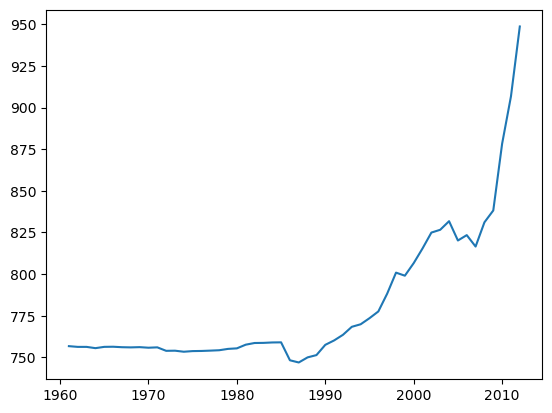

In [88]:
year_list = []
MSE_list = []
for year in range(int(lego_mod_df.Year_released.min()),int(lego_mod_df.Year_released.max())-10):
    lego_mod_postdate_df = lego_mod_df[lego_mod_df.Year_released >= year]
    y_new = lego_mod_postdate_df.Price
    X_new = lego_mod_postdate_df.drop(['Price'], axis=1)


    scaler  = preprocessing.MinMaxScaler()
    polyn = preprocessing.PolynomialFeatures(2) 

    print(year)
    numerical_transformer = Pipeline(steps=[
        ('scale', scaler),
        ('poly', polyn)
    ])

    preprocessor = ColumnTransformer(
        transformers=[('num', numerical_transformer, ['Pieces','Minifigs']),

        ],
    remainder = 'drop'
    )

    year_list.append(year)
    MSE_list.append(linear_model(preprocessor,X_new,y_new))
plt.plot(year_list, MSE_list)

Interestling, we see a dip in the MSE when setting 1987 as the cutoff date for excluding old data.
It might be possible that this is the sweet spot, where we have the most amount of data, but exclude old data which has an impact on trends that the model can evaluate. For now we'll just exclude Year_released and continue to use the whole dataset. However, we'll return to looking at a cut-off year to imrpve the model after categorical data has been included 

In [17]:
#Last time I'll define the numerical transformer, for now.
scaler  = preprocessing.MinMaxScaler()
polyn = preprocessing.PolynomialFeatures(2) 
numerical_transformer = Pipeline(steps=[
    ('scale', scaler),
    ('poly', polyn)
])



preprocessor = ColumnTransformer(
    transformers=[('num', numerical_transformer, ['Pieces','Minifigs'])
    ],
    remainder = 'drop'
)

linear_model(preprocessor,X,y)  


mean r2: train = 0.7717794359329343, test = 0.7119357643649208
mean MSE: train = 723.8377048266868, test = 756.74284054749
mean MAE: train = 11.590385030708518, test = 11.657041272242692


756.74284054749

#### Categorical Data
Next we will look at the categorical data.

Some of these features have many unique variables, whereas some have few, as such I will test to see which are better candidates for onehot, binary and target encoding.Below is an example of one such comparisson between the three varaiables for the "Subtheme" variable.

In [18]:
#Test Variable as One Hot Encoded
BI_categorical_transformer = Pipeline(steps=[
    ('Binary', BinaryEncoder(return_df=True))
    
])
OH_categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop = 'first'))
    
])

TAR_categorical_transformer = Pipeline(steps=[
    ('Target', ce.TargetEncoder())
    
])


preprocessor = ColumnTransformer(
    transformers=[('num', numerical_transformer, ['Pieces','Minifigs','Year_released']),
                  ('BI_cat', BI_categorical_transformer, ['Set_type']),
                  ('OH_cat', OH_categorical_transformer, ['Theme_group','Subtheme']),
                  ('TAR_cat', TAR_categorical_transformer, ['Theme'])
    ],
    remainder = 'drop'
)

linear_model(preprocessor,X,y)  

/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.869398872667847, test = 0.41588220593978686
mean MSE: train = 414.06756871184814, test = 1445.506166781896
mean MAE: train = 9.356037848421881, test = 24.60292791912603


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


1445.506166781896

In [19]:
#Test Variable as Binary Encoded
OH_categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop = 'first'))
    
])

TAR_categorical_transformer = Pipeline(steps=[
    ('Target', ce.TargetEncoder())
    
])
BI_categorical_transformer = Pipeline(steps=[
    ('Binary', BinaryEncoder(return_df=True))
    
])


preprocessor = ColumnTransformer(
    transformers=[('num', numerical_transformer, ['Pieces','Minifigs','Year_released']),
                  ('BI_cat', BI_categorical_transformer, ['Set_type','Subtheme']),
                  ('TAR_cat', TAR_categorical_transformer, ['Theme']),
                  ('OH_cat', OH_categorical_transformer, ['Theme_group'])
    ],
    remainder = 'drop'
)

linear_model(preprocessor,X,y)  

/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8227562201203771, test = 0.6963833235908852
mean MSE: train = 562.400871813574, test = 687.4679204130382
mean MAE: train = 11.29217270671783, test = 12.898043228244745


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


687.4679204130382

In [20]:
#Test Variable as Target Encoded
OH_categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop = 'first'))
    
])

TAR_categorical_transformer = Pipeline(steps=[
    ('Target', ce.TargetEncoder())
    
])
BI_categorical_transformer = Pipeline(steps=[
    ('Binary', BinaryEncoder(return_df=True))
    
])


preprocessor = ColumnTransformer(
    transformers=[('num', numerical_transformer, ['Pieces','Minifigs','Year_released']),
                  ('BI_cat', BI_categorical_transformer, ['Set_type']),
                  ('TAR_cat', TAR_categorical_transformer, ['Theme','Subtheme']),
                  ('OH_cat', OH_categorical_transformer, ['Theme_group'])
    ],
    remainder = 'drop'
)

linear_model(preprocessor,X,y)  


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.824496967634724, test = 0.6944511148762051
mean MSE: train = 556.3287381856042, test = 682.1424072111449
mean MAE: train = 11.398093989016962, test = 13.059755001047375


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


682.1424072111449

The below run specifies our new best model (this actually excludes subtheme from the model).

In [22]:
#Best Run
OH_categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop = 'first'))
    
])

TAR_categorical_transformer = Pipeline(steps=[
    ('Target', ce.TargetEncoder())
    
])
BI_categorical_transformer = Pipeline(steps=[
    ('Binary', BinaryEncoder(return_df=True))
    
])


preprocessor = ColumnTransformer(
    transformers=[('num', numerical_transformer, ['Pieces','Minifigs','Year_released']),
                  ('BI_cat', BI_categorical_transformer, ['Set_type']),
                  ('TAR_cat', TAR_categorical_transformer, ['Theme']),
                  ('OH_cat', OH_categorical_transformer, ['Theme_group'])
    ],
    remainder = 'drop'
)

linear_model(preprocessor,X,y)  

/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8216512434640872, test = 0.7177826978663842
mean MSE: train = 566.0474298860718, test = 667.625387925952
mean MAE: train = 11.254331245940381, test = 12.423007977317514


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


667.625387925952

As it turns out the method that minimizes the MSE involves encoding Set_type, Theme and Theme_group each a different way, and ignoring the Subtheme feature. 

Let's see how the data changes again cutting off old data at a particular year

1961


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8216512434640872, test = 0.7177826978663842
mean MSE: train = 566.0474298860718, test = 667.625387925952
mean MAE: train = 11.254331245940381, test = 12.423007977317514
1962


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8216294984160978, test = 0.7182780081130058
mean MSE: train = 566.2998713834667, test = 667.2524446394849
mean MAE: train = 11.256786224599935, test = 12.41943825817061
1963


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8216294984160978, test = 0.7182780081130058
mean MSE: train = 566.2998713834667, test = 667.2524446394849
mean MAE: train = 11.256786224599935, test = 12.41943825817061
1964


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8218439957666304, test = 0.715486548962476
mean MSE: train = 565.7235624661625, test = 673.2179405071981
mean MAE: train = 11.237894464960766, test = 12.518921495553387
1965


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8217877893249165, test = 0.7208115332338694
mean MSE: train = 566.2143042644941, test = 668.1340294357957
mean MAE: train = 11.242045657234447, test = 12.429595415502012
1966


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8217800620025301, test = 0.7222384761320538
mean MSE: train = 566.348803474529, test = 666.7768808799019
mean MAE: train = 11.243342154887051, test = 12.404031591817764
1967


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8217162753589673, test = 0.7236598999155304
mean MSE: train = 567.2130899648248, test = 666.4373556746629
mean MAE: train = 11.252645620382719, test = 12.393644856796142
1968


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8216141004303011, test = 0.7282826222026791
mean MSE: train = 568.1863881528236, test = 662.1621636972583
mean MAE: train = 11.263918090800146, test = 12.297894866019144
1969


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8216296952780506, test = 0.7211331146067643
mean MSE: train = 568.5121047164356, test = 671.5364631508406
mean MAE: train = 11.271308302852598, test = 12.491686344780517
1970


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8216219030807272, test = 0.7220951537875739
mean MSE: train = 568.8840981690653, test = 670.9759711885442
mean MAE: train = 11.273255952388496, test = 12.483504905239338
1971


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8216074463671708, test = 0.7215995044939149
mean MSE: train = 569.0956962913035, test = 671.9318413617362
mean MAE: train = 11.276203880906777, test = 12.537012322595608
1972


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8217721364906938, test = 0.7271104911217374
mean MSE: train = 569.4693603790515, test = 666.1460212084114
mean MAE: train = 11.258186393559916, test = 12.392168864234113
1973


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8217651551241953, test = 0.7272167910659192
mean MSE: train = 569.542292941451, test = 666.0669749284677
mean MAE: train = 11.258816961865268, test = 12.394761970821525
1974


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8217894551879026, test = 0.725110215282586
mean MSE: train = 569.6548653333509, test = 668.5098540672501
mean MAE: train = 11.254448484075306, test = 12.451924190743522
1975


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8044637348522391, test = 0.6601000438032436
mean MSE: train = 626.9043685361888, test = 805.3214933323572
mean MAE: train = 12.78623748597047, test = 15.058393421750177
1976


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8217802867472365, test = 0.7263910828362016
mean MSE: train = 569.9307587272408, test = 667.5260566478657
mean MAE: train = 11.257118182012265, test = 12.43631563325008
1977


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8222316620947293, test = 0.7278288468185562
mean MSE: train = 568.9372725591354, test = 665.6312734786353
mean MAE: train = 11.238076453340781, test = 12.406129786560019
1978


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8222372000380712, test = 0.7279072208232931
mean MSE: train = 569.0754127282603, test = 665.9708498111646
mean MAE: train = 11.239647344923052, test = 12.418237954402475
1979


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8222864225454488, test = 0.7297023076437548
mean MSE: train = 569.4000915503646, test = 664.5890792901557
mean MAE: train = 11.243752172882045, test = 12.404141464540864
1980


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8225802047762196, test = 0.7292581854301362
mean MSE: train = 568.6901892139757, test = 664.9760468289609
mean MAE: train = 11.233609832399077, test = 12.427670060565124
1981


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8231362408196707, test = 0.7313405640272475
mean MSE: train = 568.5770476403388, test = 664.4577162833341
mean MAE: train = 11.22710176061567, test = 12.471656507201015
1982


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8232780788642275, test = 0.7313854857022372
mean MSE: train = 569.1029337334583, test = 665.4412587582975
mean MAE: train = 11.223526223554193, test = 12.506221578461865
1983


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8232360541977453, test = 0.7327497070204265
mean MSE: train = 569.5285718058307, test = 664.0523934892774
mean MAE: train = 11.230927820095701, test = 12.460506906120274
1984


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8233931732143839, test = 0.7329490087208812
mean MSE: train = 569.2496896877878, test = 664.0121973962216
mean MAE: train = 11.225790893390492, test = 12.461876348594966
1985


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.823449723111976, test = 0.7302549669565622
mean MSE: train = 570.2320222876978, test = 668.0298213316566
mean MAE: train = 11.235505224403095, test = 12.556405409951775
1986


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8236279472784089, test = 0.736563959485005
mean MSE: train = 571.4570810315614, test = 660.9118095414404
mean MAE: train = 11.24198324379387, test = 12.530801249175164
1987


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8242276807134117, test = 0.7375100240723231
mean MSE: train = 570.7952812189676, test = 663.7505340973352
mean MAE: train = 11.22640972589144, test = 12.592978327460495
1988


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8241480434040872, test = 0.7396238502443686
mean MSE: train = 573.187968012115, test = 663.0627181769374
mean MAE: train = 11.263732939748346, test = 12.549649831884423
1989


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.824183441572028, test = 0.7389560915430572
mean MSE: train = 574.0502332882631, test = 664.9894861623601
mean MAE: train = 11.270036831495606, test = 12.58817065190065
1990


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8240622852016045, test = 0.7321696674843123
mean MSE: train = 576.7531875599773, test = 678.0329788487079
mean MAE: train = 11.307685323636607, test = 12.832476159551618
1991


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8239963993767434, test = 0.7305247475687798
mean MSE: train = 578.6635397121304, test = 681.429051697806
mean MAE: train = 11.323978194835052, test = 12.887051571958338
1992


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8242573098950304, test = 0.7331654099672162
mean MSE: train = 580.4159418606807, test = 678.913936739505
mean MAE: train = 11.33652666153694, test = 12.856666039099599
1993


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8242768782989639, test = 0.7327191529825685
mean MSE: train = 583.2637788221787, test = 687.9069265700522
mean MAE: train = 11.363277730651943, test = 13.065606556228712
1994


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.825563889925552, test = 0.7167437340415864
mean MSE: train = 583.3161197099136, test = 781.1748931196664
mean MAE: train = 11.371460184188006, test = 14.116227473781397
1995


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.825934698409062, test = 0.7206906939458838
mean MSE: train = 584.5299503545249, test = 780.1960906994369
mean MAE: train = 11.395346085779863, test = 14.025262425479685
1996


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8270420166816095, test = 0.7338633698094468
mean MSE: train = 585.4816355700593, test = 770.1714054193149
mean MAE: train = 11.404574005039883, test = 13.716995026021475
1997


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8268022065861758, test = 0.7431718134112134
mean MSE: train = 592.3427251928581, test = 770.8398821731992
mean MAE: train = 11.462613502724832, test = 13.188039161714949
1998


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8277802620084029, test = 0.7519549188970314
mean MSE: train = 596.8047235433745, test = 772.3898654935698
mean MAE: train = 11.503560435439457, test = 12.950960860846019
1999


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8303849766646344, test = 0.7814872976086866
mean MSE: train = 596.83279523022, test = 645.050598326024
mean MAE: train = 11.481511662490144, test = 11.872422308429359
2000


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8316515301927639, test = 0.7883915801163701
mean MSE: train = 599.7402380053101, test = 652.7344557738403
mean MAE: train = 11.486093338294165, test = 11.998376026644625
2001


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8331673737889946, test = 0.7858570078369601
mean MSE: train = 601.85628202977, test = 678.1311635611097
mean MAE: train = 11.456782103397208, test = 12.463811652132907
2002


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8341864739649774, test = 0.7873896192675482
mean MSE: train = 606.2938250797904, test = 680.8904203641149
mean MAE: train = 11.490070313097197, test = 12.444695705524156
2003


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8368710327223956, test = 0.7967360217108337
mean MSE: train = 605.8301454956046, test = 675.9872374098248
mean MAE: train = 11.447882279653307, test = 12.237403939347024
2004


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8381985850190187, test = 0.7861808953158416
mean MSE: train = 612.122991213919, test = 719.9648582317875
mean MAE: train = 11.493065013467065, test = 12.844463586231688
2005


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8413292962797915, test = 0.802990616175955
mean MSE: train = 610.9166651408883, test = 693.5645771861867
mean MAE: train = 11.463458258752906, test = 12.411896290626903
2006


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.843033702338017, test = 0.7991695770128289
mean MSE: train = 613.2585365983444, test = 713.7276179909375
mean MAE: train = 11.44490666689499, test = 12.699925867365309
2007


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8473809719506862, test = 0.8056651613095269
mean MSE: train = 606.0865257902351, test = 709.3188615720104
mean MAE: train = 11.352312818982027, test = 12.49251421377097
2008


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8474010010940713, test = 0.8029021363104704
mean MSE: train = 609.1690244242927, test = 723.6807090025432
mean MAE: train = 11.359189893695794, test = 12.394723470970193
2009


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8468644405003565, test = 0.8171790030244992
mean MSE: train = 619.4677219964241, test = 697.4963439433839
mean MAE: train = 11.386022551709235, test = 11.984252065517202
2010


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8489674071145428, test = 0.806614849942496
mean MSE: train = 622.5718073865723, test = 752.5914221532009
mean MAE: train = 11.416060074613446, test = 12.199312763852976
2011


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8489538079943937, test = 0.8102125866726146
mean MSE: train = 631.4273429826608, test = 771.7324528579795
mean MAE: train = 11.509130443714547, test = 12.234050957806133
2012


/usr/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


mean r2: train = 0.8510239482438667, test = 0.8072337904299844
mean MSE: train = 639.2328832764626, test = 808.3715514103626
mean MAE: train = 11.650364685539664, test = 12.344167928640726


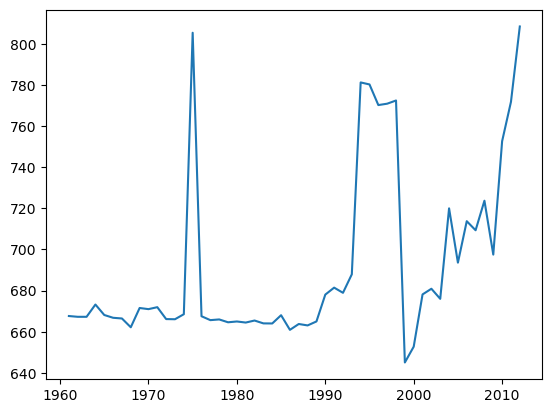

In [23]:
year_list=[]
MSE_list =[]
for year in range(int(lego_mod_df.Year_released.min()),int(lego_mod_df.Year_released.max())-10):
    lego_mod_postdate_df = lego_mod_df[lego_mod_df.Year_released >= year]
    y_new = lego_mod_postdate_df.Price
    X_new = lego_mod_postdate_df.drop(['Price'], axis=1)
    print(year)
    
    year_list.append(year)
    MSE_list.append(linear_model(preprocessor,X_new,y_new))
plt.plot(year_list, MSE_list)

Interstingly enough the shape of the graph has completely changed!
While we could lower the MSE of the model by cutting off in the year 1999, this would exclude a lot of data, without really having a good reason, I'll keep all of the data included.

This leaves our best achieved MSE: 667.625387925952
